In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

# IMPORTANDO DADOS

In [258]:
df = pd.read_csv('../DataBase.csv')
df

,ax,ay,az,gx,gy,gz,time
0,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512,0.002044
1,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512,0.005294
2,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457,0.018674
3,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141,0.021819
4,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035,0.035171
...,...,...,...,...,...,...,...
893,-0.046387,-0.035645,-1.042969,-3.723145,-1.159668,2.990723,8.259801
894,-0.051758,-0.042969,-1.040039,-2.746582,-0.061035,4.028320,8.273132
895,-0.057617,-0.035156,-1.039551,-2.380371,-0.305176,4.211426,8.276249
896,-0.060547,-0.018555,-1.047852,-2.197266,-0.244141,4.394531,8.289582


# NORMALIZANDO DADOS

In [259]:
dt = float(np.round(df.time.diff().mean(), 3))
dt

0.009

In [260]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.000,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512
1,0.009,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512
2,0.018,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457
3,0.027,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141
4,0.036,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035


# CONVERSÃO DE UNIDADES
Os sensores entregam dados em unidades digitais (LSB), que precisam ser convertidas para m/s² (aceleração) e rad/s (velocidade angular) para fazer cálculos físicos corretos, como integração e rotação.

In [261]:
# Acelerômetro: ±2g → 16384 LSB/g, g = 9.81 m/s²
df['ax'] = (df['ax'] / 16384.0) * 9.81
df['ay'] = (df['ay'] / 16384.0) * 9.81
df['az'] = (df['az'] / 16384.0) * 9.81

# Giroscópio: ±250°/s → 131 LSB/(°/s), converter para rad/s
df['gx'] = (df['gx'] / 131.0) * (np.pi / 180)
df['gy'] = (df['gy'] / 131.0) * (np.pi / 180)
df['gz'] = (df['gz'] / 131.0) * (np.pi / 180)

df.head()

,time,ax,ay,az,gx,gy,gz
0,0.000,-0.000050,-0.000043,-0.000607,-0.000943,-0.000301,-0.000350
1,0.009,-0.000048,-0.000042,-0.000605,-0.001057,-0.000398,-0.000350
2,0.018,-0.000042,-0.000046,-0.000612,-0.001236,-0.000659,-0.000106
3,0.027,-0.000043,-0.000044,-0.000619,-0.001277,-0.000642,-0.000033
4,0.036,-0.000053,-0.000049,-0.000632,-0.001366,-0.000529,-0.000008


# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

### Aceleração Linear

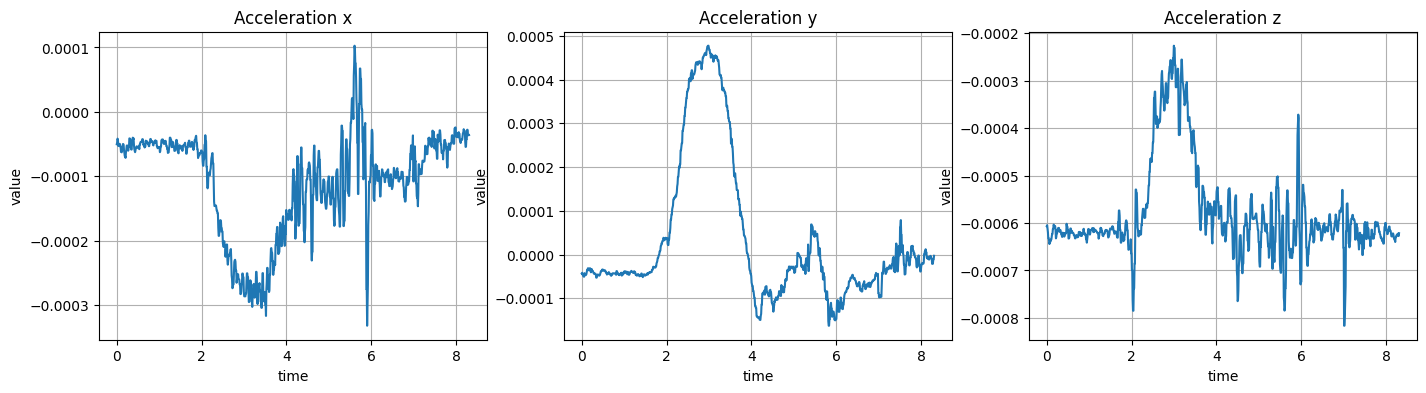

In [262]:
plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.ax)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.ay)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.az)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration z')
plt.grid()

- Aplicando Filtro Passa Faixa

TransferFunction(array([6.28318531, 0.        ]), array([ 1.        ,  6.28318531, 29.6088132 ]))

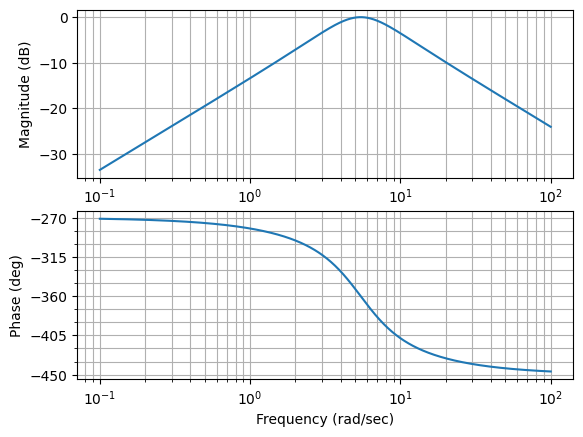

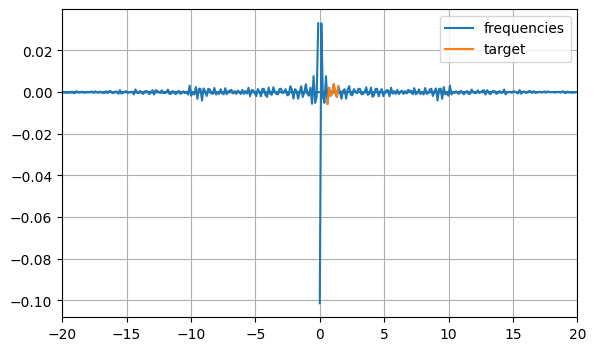

In [263]:
target = (0.5, 1.5)

filter = BandFilter(dt, target)
filter.plot()
NumpyFilter().see(df.ax.values, dt, target, range=(-20, 20))

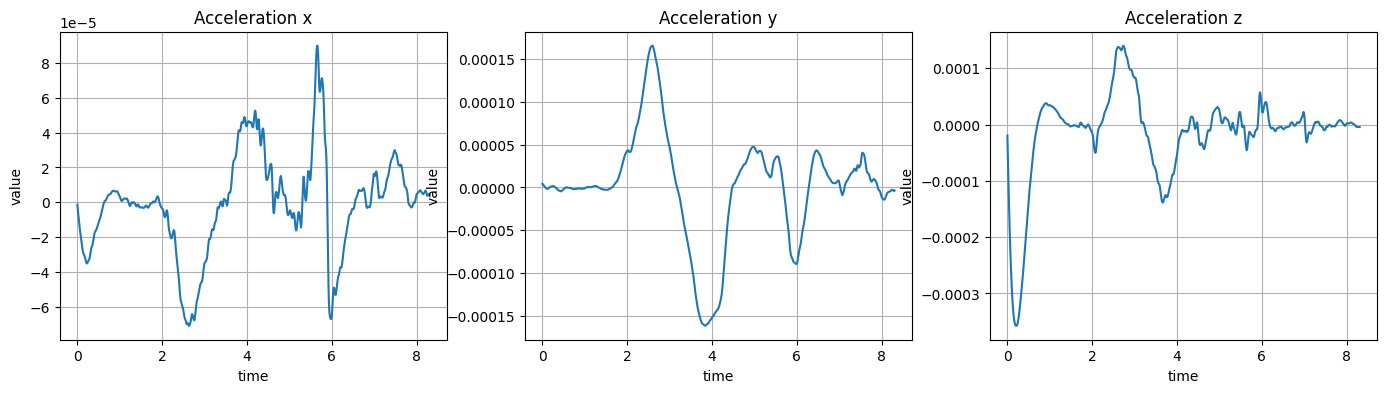

In [264]:
for col in ['ax', 'ay', 'az']: df[col] = filter.apply(df[col])

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.ax)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.ay)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.az)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Acceleration z')
plt.grid()

### Velocidade Linear

Xn*(0.004500) + Xn1*(0.004500) + Yn1*(1.000000);


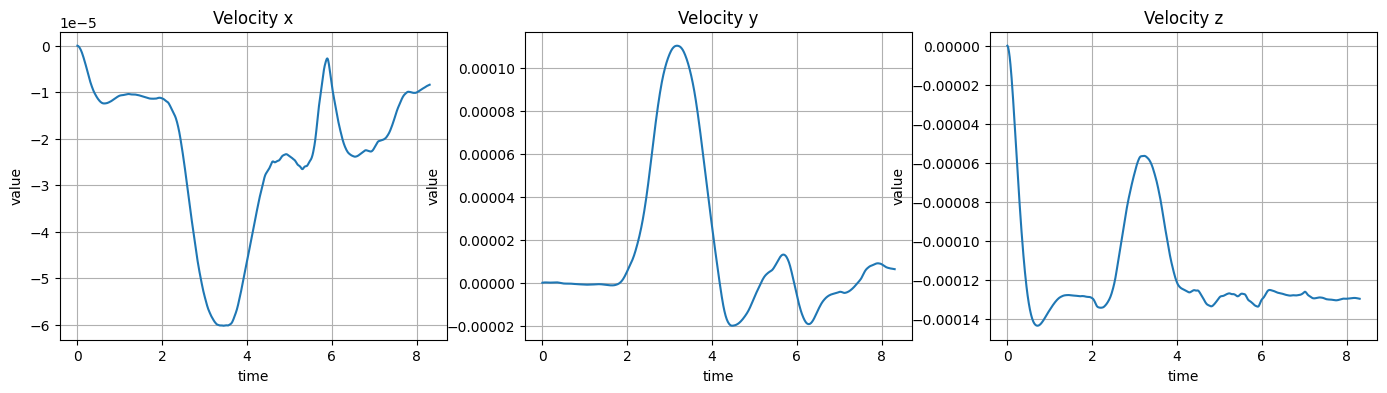

In [265]:
integral = Integral(dt)
df['vx'] = [integral.update(x) for x in df.ax]
integral.reset()

df['vy'] = [integral.update(y) for y in df.ay]
integral.reset()

df['vz'] = [integral.update(z) for z in df.az]
integral.reset()

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.vx)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Velocity x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.vy)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Velocity y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.vz)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Velocity z')
plt.grid()

### Posição Linear

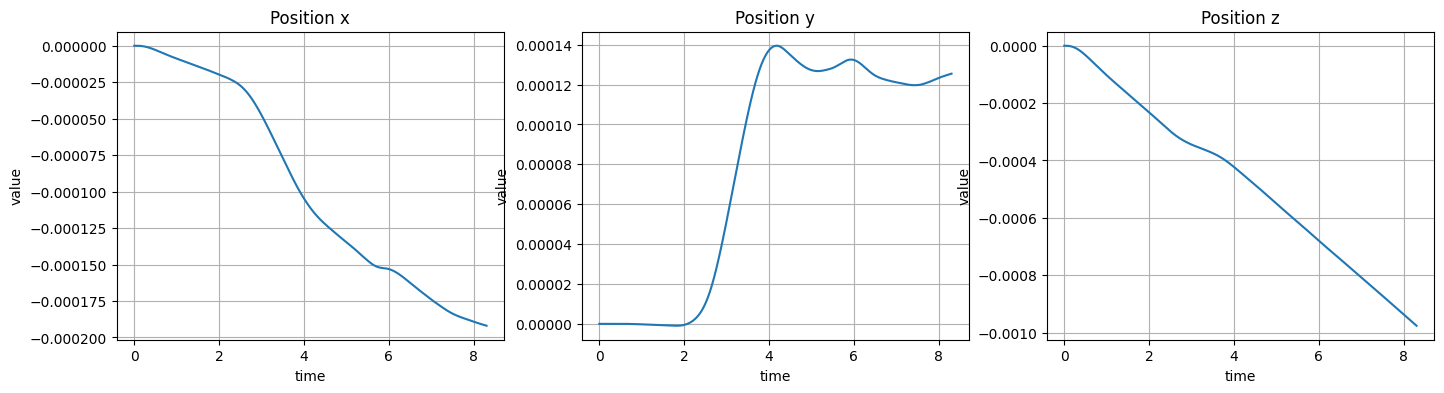

In [266]:
df['x'] = [integral.update(x) for x in df.vx]
integral.reset()

df['y'] = [integral.update(y) for y in df.vy]
integral.reset()

df['z'] = [integral.update(z) for z in df.vz]
integral.reset()

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.x)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Position x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.y)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Position y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.z)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Position z')
plt.grid()

### Campo Vetorial

(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), None)

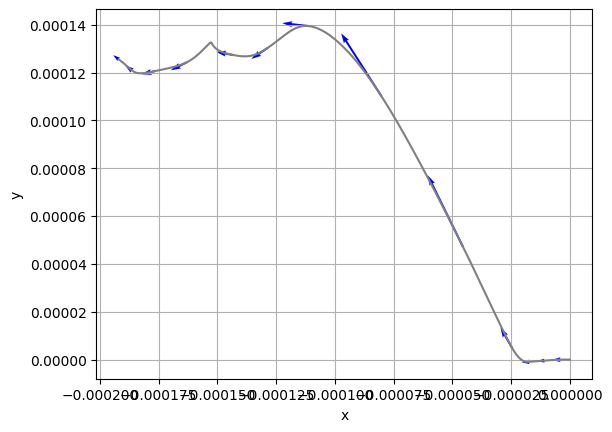

In [267]:
indices = np.linspace(0, len(df)-1, 15, dtype=int)
xData = df.x.values[indices]
yData = df.y.values[indices]
uData = df.vx[indices]
vData = df.vy[indices]

plt.plot(df.x, df.y, color='gray')
plt.quiver(xData, yData, uData, vData, angles='xy', scale_units='xy', scale=3.5, width=0.004, color='blue')
plt.xlabel('x'), plt.ylabel('y'), plt.grid()

(Text(0.5, 0, 'X'), Text(0.5, 0.5, 'Y'), Text(0.5, 0, 'Z'))

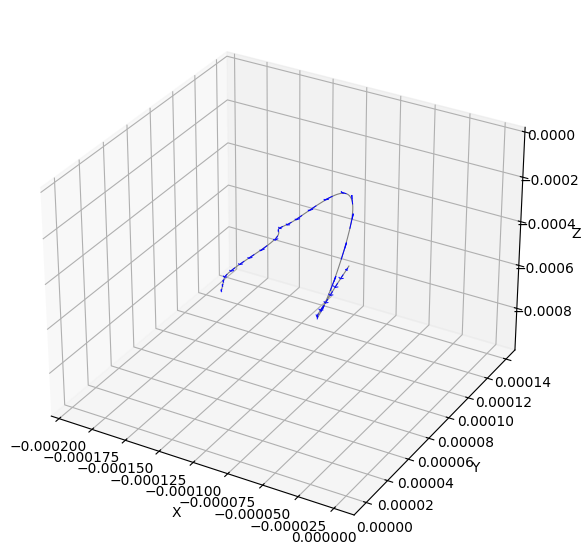

In [268]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(df)-1, 30, dtype=int)

xData = df.x.values[indices]
yData = df.y.values[indices]
zData = df.z.values[indices]
uData = df.vx[indices]
vData = df.vy[indices]
wData = df.vz[indices] 

ax.plot(df.x, df.y, df.z, lw=0.8, color='gray')
ax.quiver(xData, yData, zData, uData, vData, wData, length=0.15, normalize=False, color='blue', linewidth=.7)
ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')

# INCLINAÇÃO
### Velocidade Angular

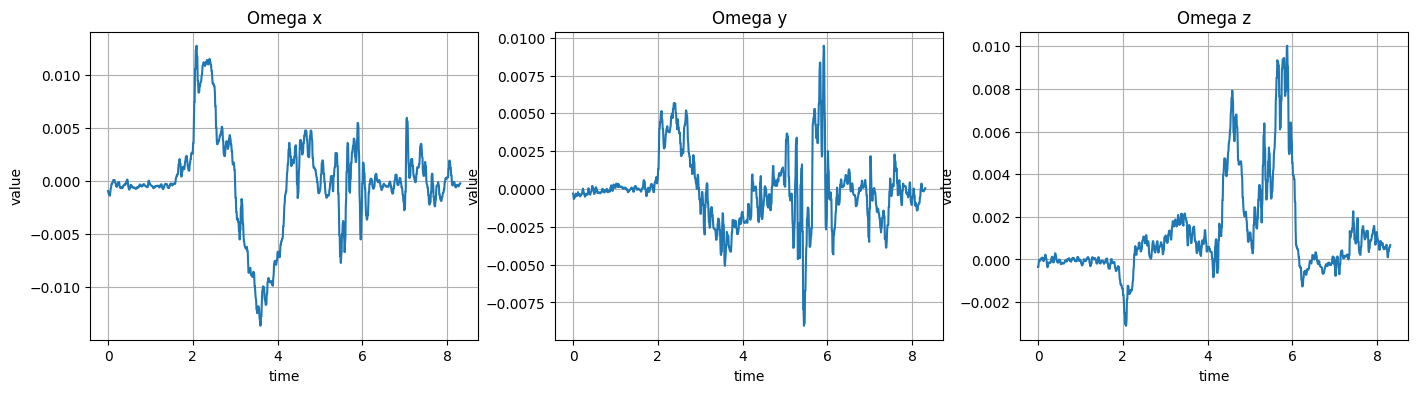

In [269]:
plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.gx)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.gy)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.gz)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega z')
plt.grid()

TransferFunction(array([157.91367042]), array([  1.        ,  17.77153175, 157.91367042]))

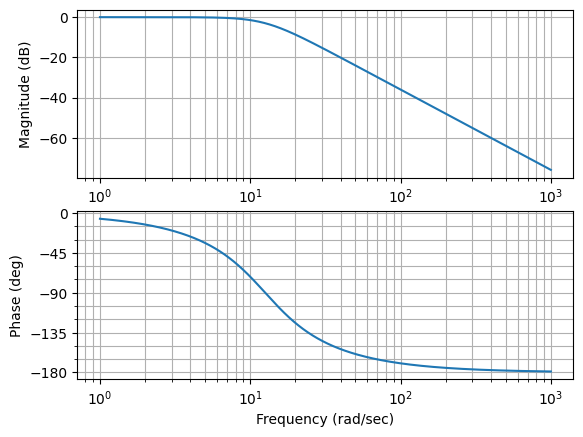

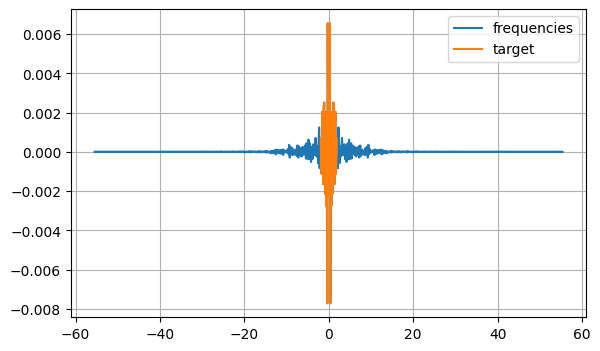

In [270]:
filter = LowBandFilter(f_c=2, dt=dt)
filter.plot()
NumpyFilter().see(df.ax.values, dt, (-2, 2))

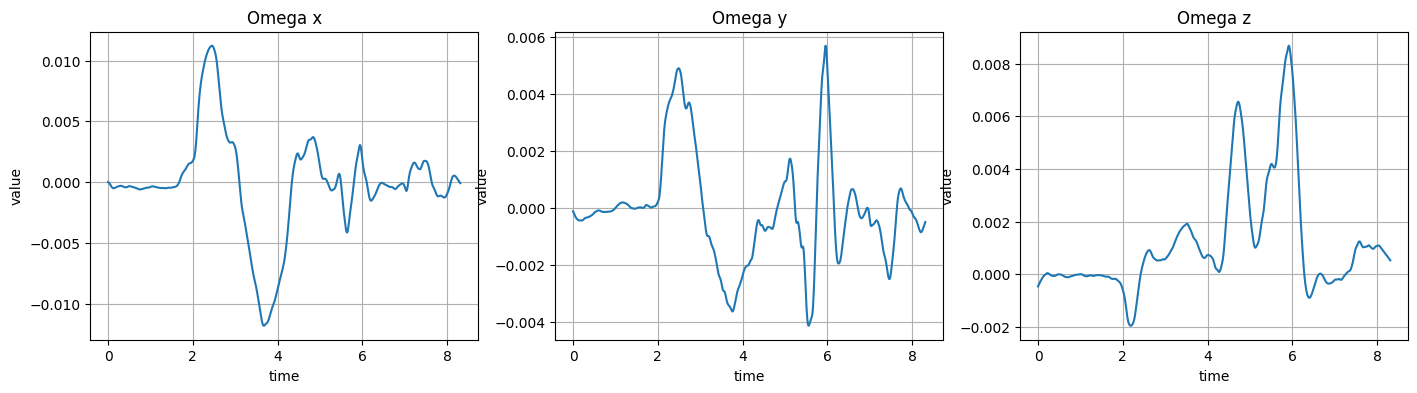

In [271]:
for col in ['gx', 'gy', 'gz']: df[col] = filter.apply(df[col])

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.gx)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.gy)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.gz)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Omega z')
plt.grid()

### Ângulo

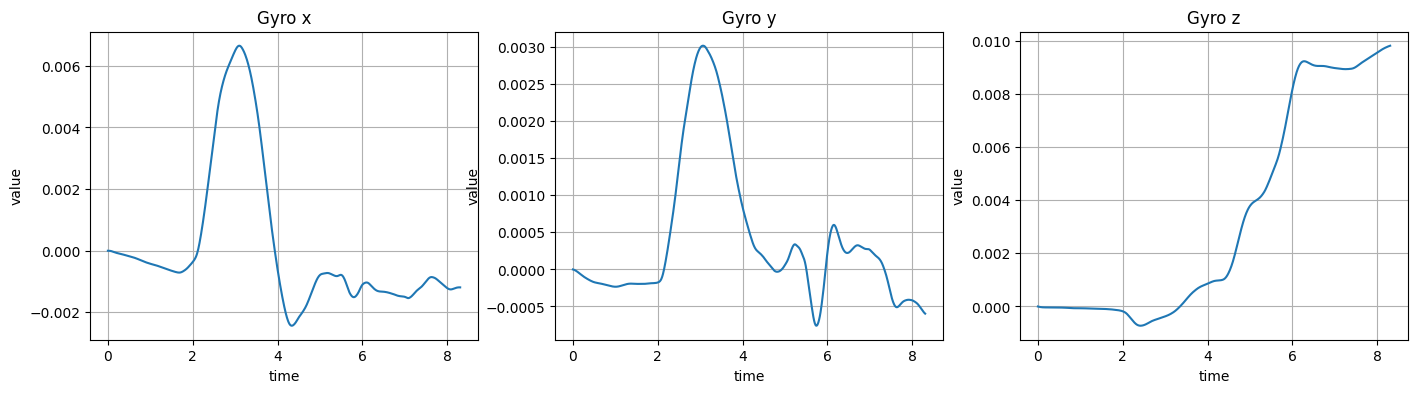

In [272]:
df['theta_x'] = [integral.update(x) for x in df.gx]
integral.reset()

df['theta_y'] = [integral.update(y) for y in df.gy]
integral.reset()

df['theta_z'] = [integral.update(z) for z in df.gz]
integral.reset()

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(df.time, df.theta_x)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Gyro x')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(df.time, df.theta_y)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Gyro y')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(df.time, df.theta_z)
plt.xlabel('time'), plt.ylabel('value')
plt.title('Gyro z')
plt.grid()

### Campo Vetorial

(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), None)

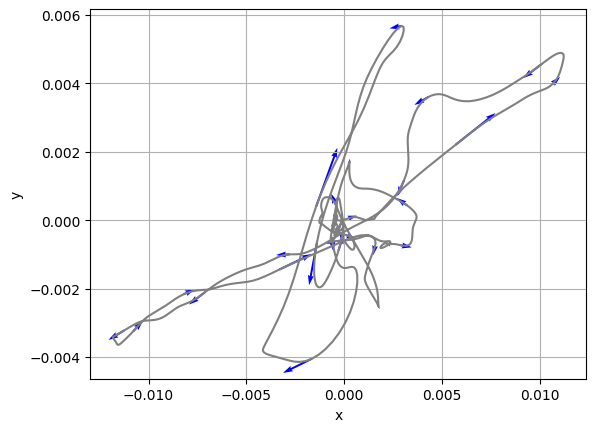

In [273]:
indices = np.linspace(0, len(df)-1, 40, dtype=int)
xData = df.gx.values[indices]
yData = df.gy.values[indices]
uData = np.gradient(df.gx.values, df.time.values)[indices]
vData = np.gradient(df.gy.values, df.time.values)[indices]

plt.plot(df.gx, df.gy, color='gray')
plt.quiver(xData, yData, uData, vData, angles='xy', scale_units='xy', scale=25, width=0.004, color='blue')
plt.xlabel('x'), plt.ylabel('y'), plt.grid()

(Text(0.5, 0, 'X'), Text(0.5, 0.5, 'Y'), Text(0.5, 0, 'Z'))

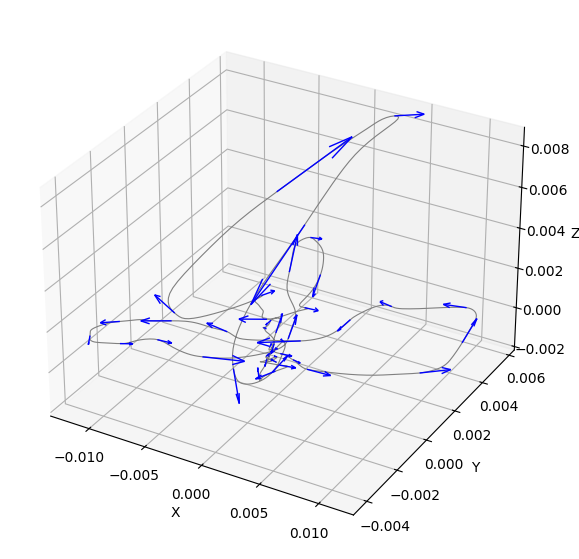

In [274]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(df)-1, 50, dtype=int)

xData = df.gx.values[indices]
yData = df.gy.values[indices]
zData = df.gz.values[indices]
uData = np.gradient(df.gx.values, df.time.values)[indices]
vData = np.gradient(df.gy.values, df.time.values)[indices]
wData = np.gradient(df.gz.values, df.time.values)[indices]

ax.plot(df.gx, df.gy, df.gz, lw=0.8, color='gray')
ax.quiver(xData, yData, zData, uData, vData, wData, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')